# 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from os import listdir
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam


# 2. Defining Necessary Functions 

In [2]:
# Function to convert images to arrays
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, (256, 256))
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# Function to load dataset from a directory (train or test)
def load_dataset(data_dir):
    image_list, label_list = [], []
    for directory in listdir(data_dir):
        plant_image_list = listdir(f"{data_dir}/{directory}")
        for files in plant_image_list:
            image_path = f"{data_dir}/{directory}/{files}"
            image_list.append(convert_image_to_array(image_path))
            label_list.append(binary_labels[all_labels.index(directory)])
    return image_list, label_list

# Function to plot the test images
def output_plot(image, model):
    class_labels = classes
    fig, axs = plt.subplots(1, 2, figsize=(10, 2))

    predictions = model.predict(image.reshape(1, 256, 256, 3))

    axs[0].imshow(array_to_img(image))
    axs[0].axis('off')
    prediction_values = predictions[0]

    max_index = np.argmax(prediction_values)
    colors = ['green' if i == max_index else 'blue' for i in range(len(class_labels))]

    axs[1].barh(class_labels, prediction_values, color=colors)
    axs[1].set_xlim([0, 1])

    plt.tight_layout()
    plt.show()



# 3. Loading the Data

In [3]:
dir_path = r"/Users/admin/Downloads/mangodataset"

all_labels = [i.split('/')[-1] for i in os.listdir(dir_path)]
binary_labels = [int(i) for i in range(len(all_labels))]

images, labels = load_dataset(dir_path)

In [4]:
all_labels

['Powdery Mildew',
 'Cutting Weevil',
 'Anthracnose',
 'Bacterial Canker',
 'Sooty Mould',
 'Gall Midge',
 'Healthy',
 'Die Back']

In [5]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.05, random_state=42  # 20% for testing
)

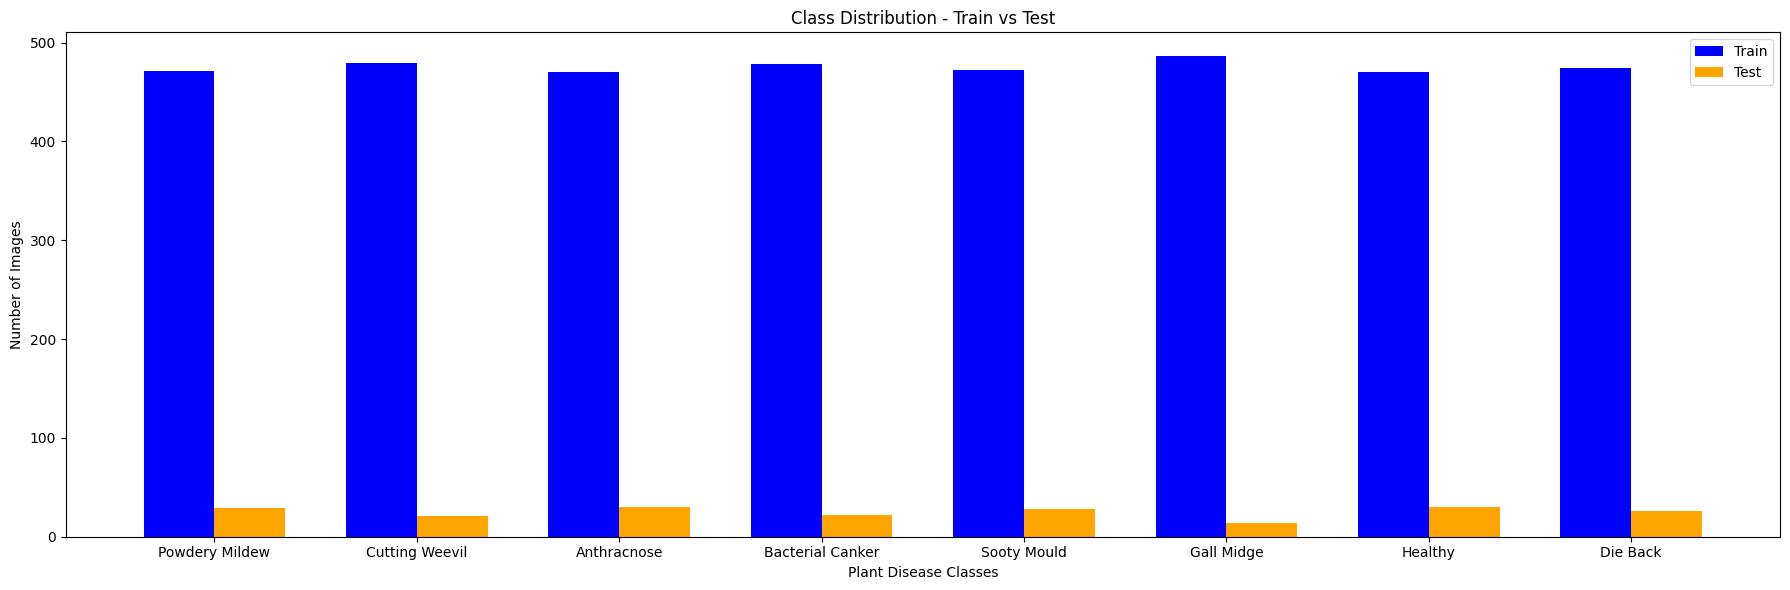

In [6]:
train_class_counts = np.bincount(train_labels)
test_class_counts = np.bincount(test_labels, minlength=3)

classes = all_labels
train_colors = 'blue'
test_colors = 'orange'
bar_width = 0.35
index = np.arange(len(classes))
plt.figure(figsize=(18, 6))
plt.bar(index, train_class_counts, width=bar_width, color=train_colors, label='Train')
plt.bar(index + bar_width, test_class_counts, width=bar_width, color=test_colors, label='Test')
plt.xlabel("Plant Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution - Train vs Test")
plt.xticks(index + bar_width / 2, classes)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Pre-processing Data

In [7]:
# Normalize image data (convert pixel values to range 0-1)
x_train = np.array(train_images, dtype=np.float16) / 255.0
x_test = np.array(test_images, dtype=np.float16) / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(np.array(train_labels), num_classes=len(classes))
y_test = to_categorical(np.array(test_labels), num_classes=len(classes))

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


x_train shape: (3800, 256, 256, 3)
x_test shape: (200, 256, 256, 3)
y_train shape: (3800, 8)
y_test shape: (200, 8)


# 5. Visualization

## 5.1. Sample Train Images

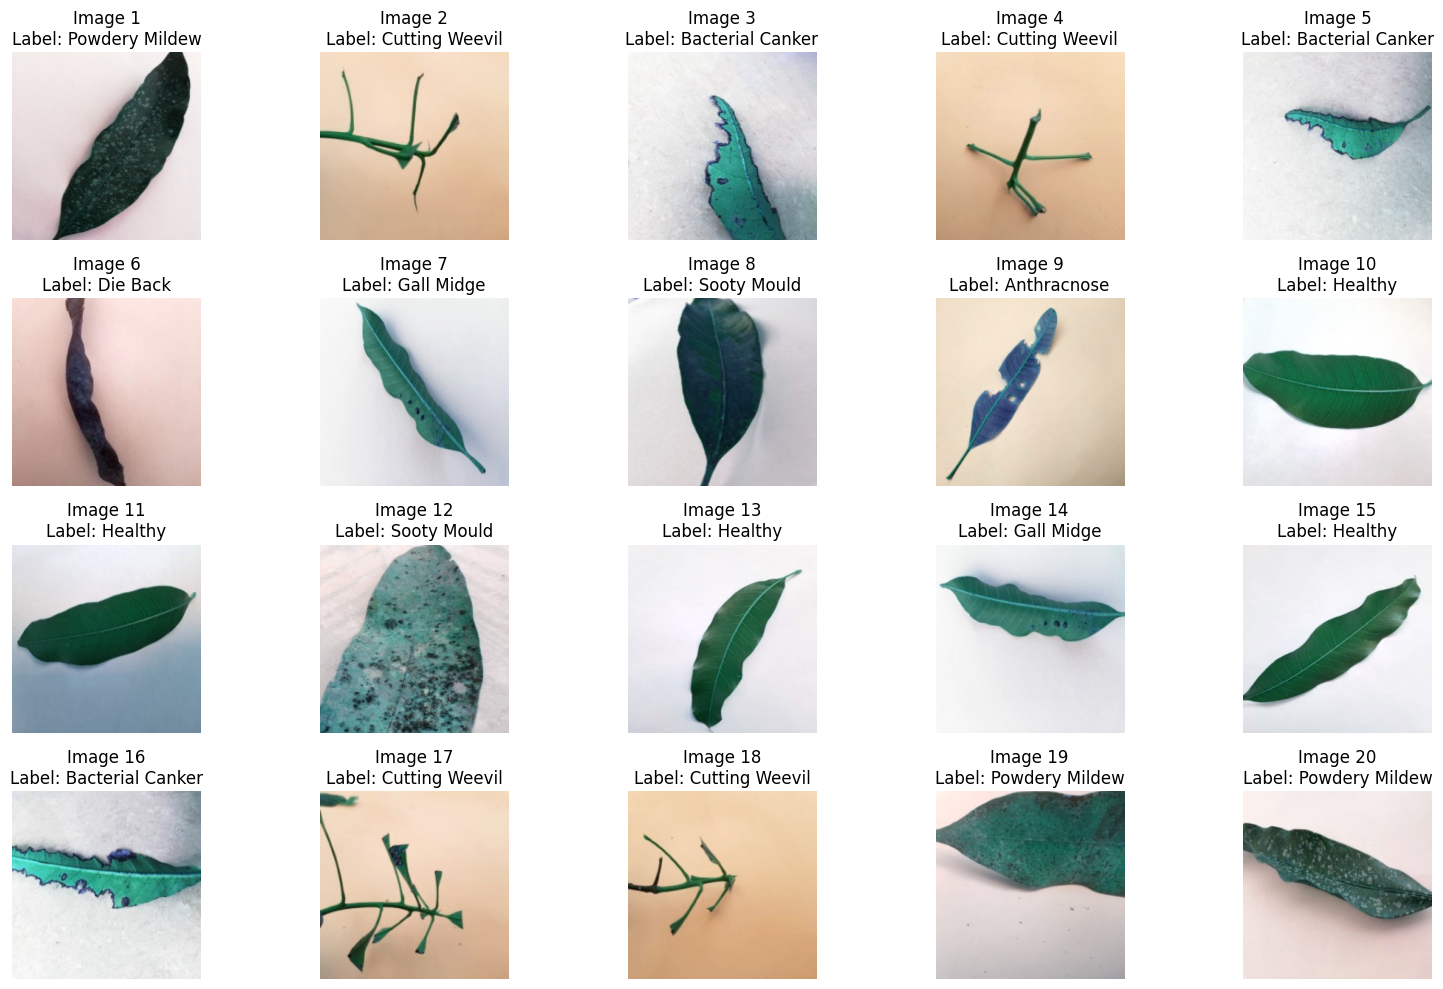

In [8]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_train)), 20)

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_train[idx]))
    label = np.argmax(y_train[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 5.2 Sample Test Images

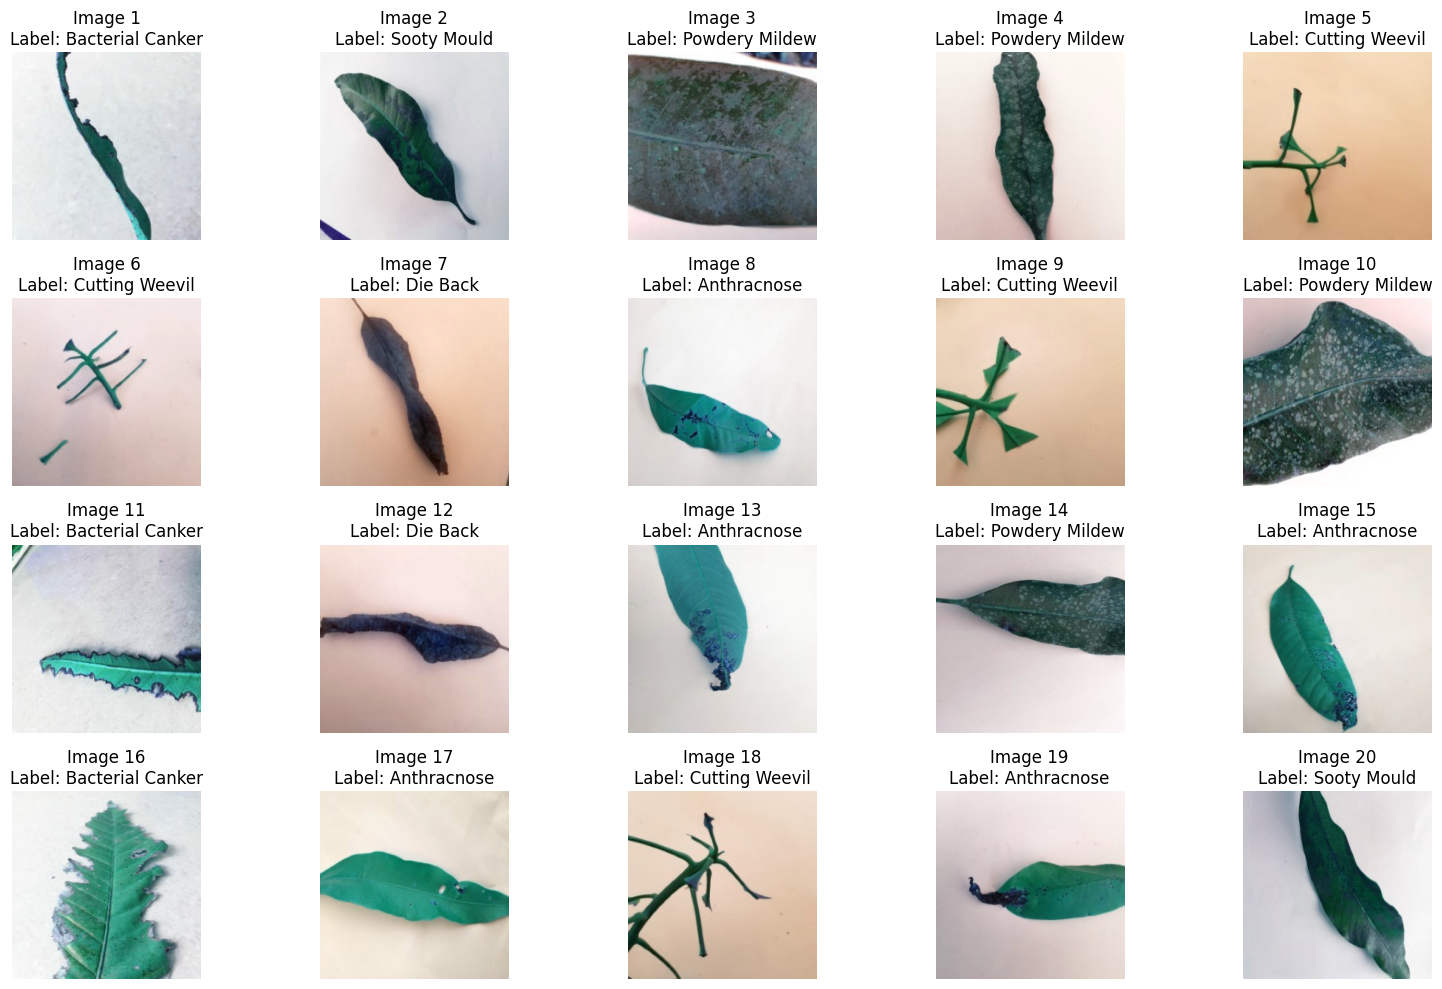

In [9]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_test)), 20)

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_test[idx]))
    label = np.argmax(y_test[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 6. Model Definition

In [13]:
from tensorflow.keras.regularizers import l2

# Function to build models using popular CNN architectures
def build_model(model_name):
    if model_name == 'VGG16':
        base_model = VGG16(include_top=False, input_shape=(256, 256, 3))
    elif model_name == 'VGG19':
        base_model = VGG19(include_top=False, input_shape=(256, 256, 3))
    elif model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, input_shape=(256, 256, 3))
    elif model_name == 'DenseNet121':
        base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3))
    else:
        base_model = Sequential([
            Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(256, 256, 3)),
            MaxPooling2D(pool_size=(3, 3), strides=2),
            Conv2D(256, (5, 5), padding="same", activation='relu'),
            MaxPooling2D(pool_size=(3, 3), strides=2),
            Conv2D(384, (3, 3), padding="same", activation='relu'),
            Conv2D(384, (3, 3), padding="same", activation='relu'),
            Conv2D(256, (3, 3), padding="same", activation='relu'),
            MaxPooling2D(pool_size=(3, 3), strides=2),
            Flatten(),
            Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.6),
            Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.6),
            Dense(len(classes), activation='softmax')
        ])
        return base_model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.6),
        Dense(len(classes), activation='softmax')
    ])

    return model


# 7. Model Training

Training VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1730091611.077927     112 service.cc:145] XLA service 0x7b5c680044d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730091611.078013     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730091611.078022     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730091647.948467     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 ━━━━━━━━━━━━━━━━━━━━ 110s 566ms/step - accuracy: 0.3284 - loss: 7.8188 - val_accuracy: 0.8994 - val_loss: 4.7642
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 267ms/step - accuracy: 0.8238 - loss: 4.5040 - val_accuracy: 0.9897 - val_loss: 3.1256
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 269ms/step - accuracy: 0.9375 - loss: 3.0532 - val_accuracy: 0.9877 - val_loss: 2.3127
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 271ms/step - accuracy: 0.9751 - loss: 2.2049 - val_accuracy: 0.9918 - val_loss: 1.8140
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 272ms/step - accuracy: 0.9911 - loss: 1.7044 - val_accuracy: 0.9897 - val_loss: 1.4864
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 272ms/step - accuracy: 0.9768 - loss: 1.4382 - val_accuracy: 0.9384 - val_loss: 1.3712
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 273ms/step - accuracy: 0.9472 - loss: 1.3860 - val_accuracy: 0.9938 - val_loss: 1.0875
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 274ms/step - accuracy: 0.9768 - loss: 1.1267 - va

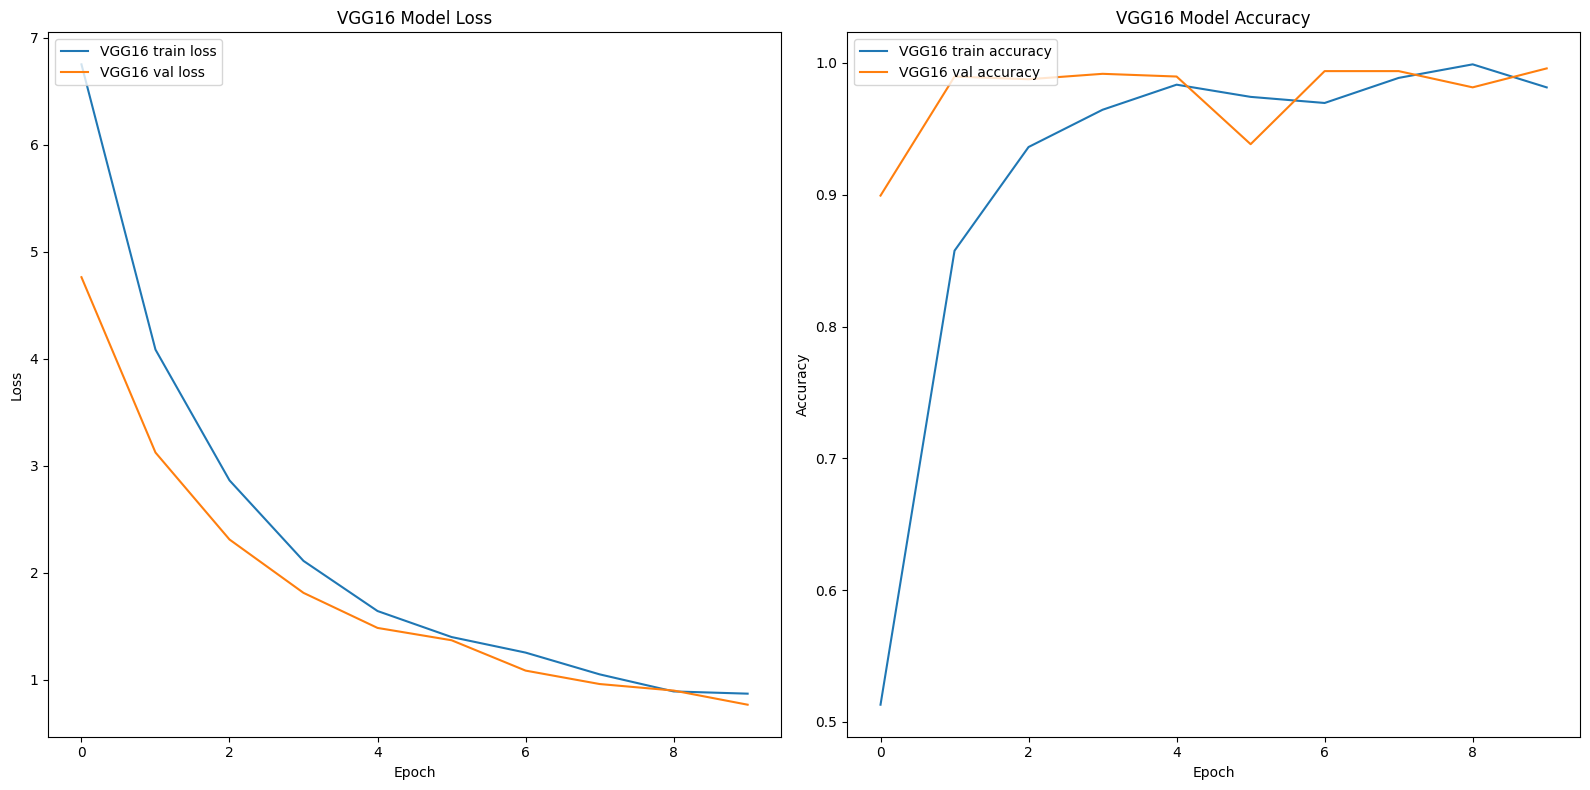

Training VGG19 model...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 374ms/step - accuracy: 0.3957 - loss: 7.7394 - val_accuracy: 0.9302 - val_loss: 5.0122
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 40s 326ms/step - accuracy: 0.8738 - loss: 4.7586 - val_accuracy: 0.8522 - val_loss: 4.2320
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 40s 327ms/step - accuracy: 0.8914 - loss: 3.6369 - val_accuracy: 0.9425 - val_loss: 2.8944
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 40s 327ms/step - accuracy: 0.9665 - loss: 2.6646 - val_accuracy: 0.9466 - val_loss: 2.3322
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 40s 328ms/step - accuracy: 0.9730 - loss: 2.1432 - val_accuracy: 0.9856 - val_loss: 1.8270
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 40s 328ms/step - accuracy: 0.9763 - loss: 1.7659 - val_accuracy: 1.0000 - val_loss: 1.4906
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 40s 328ms/step - accuracy: 1.0000 - loss: 1.4308 - val_accuracy: 1.0000 - val_loss: 1.2704
Epoch 8/

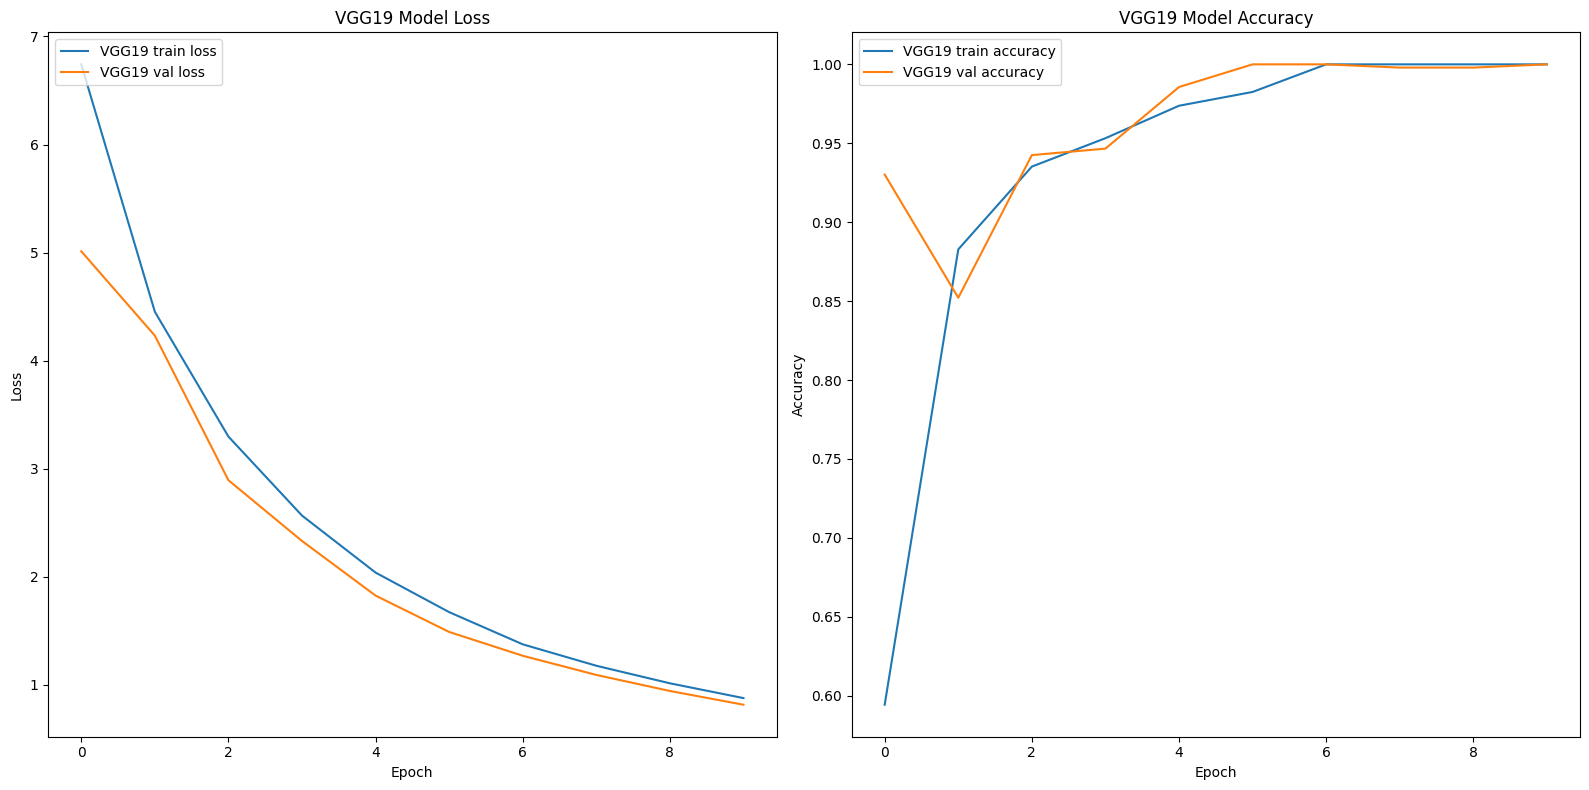

Training ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 114s 454ms/step - accuracy: 0.7651 - loss: 13.8288 - val_accuracy: 0.0945 - val_loss: 13.6837
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - accuracy: 0.9821 - loss: 10.6404 - val_accuracy: 0.1150 - val_loss: 11.1805
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - accuracy: 0.9823 - loss: 8.2183 - val_accuracy: 0.1992 - val_loss: 9.2572
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.9830 - loss: 6.2587 - val_accuracy: 0.1602 - val_loss: 7.5996
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 187ms/step - accuracy: 0.9931 - loss: 4.6892 - val_accuracy: 0.1499 - val_loss: 6.2370
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - accuracy: 0.9911 - loss: 3.5127 - val_accuracy: 0.3758 - val_loss: 5.4398
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - accuracy: 0.9883 - loss: 2.6347 - val_accuracy: 0.5770 - val_loss: 3.4107


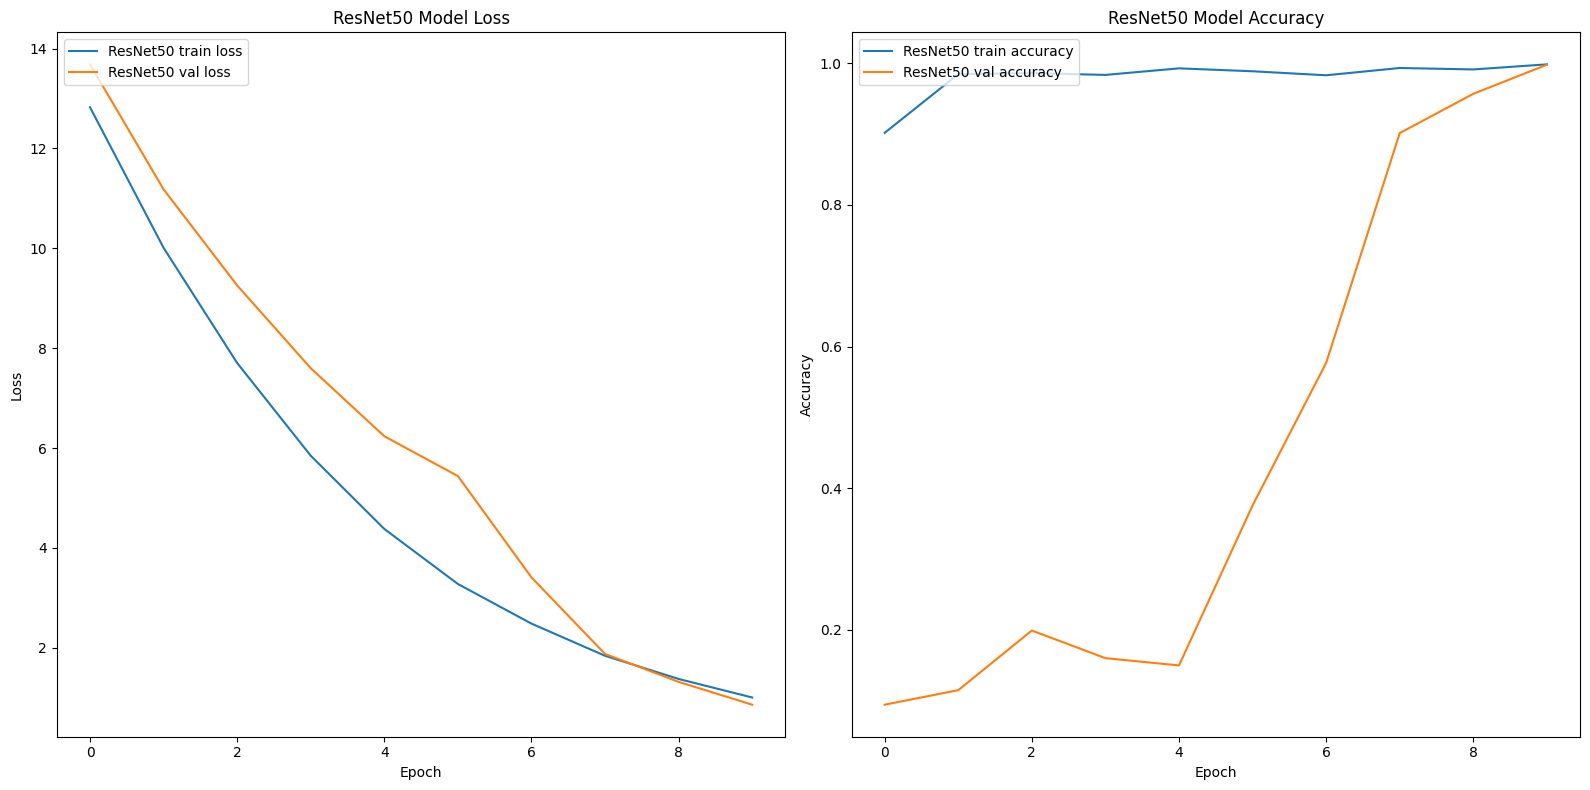

Training DenseNet121 model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1730092940.522058     109 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion_3', 4 bytes spill stores, 4 bytes spill loads



122/122 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.6284 - loss: 10.4978 - val_accuracy: 0.9179 - val_loss: 7.5145
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - accuracy: 0.9853 - loss: 6.7482 - val_accuracy: 0.9918 - val_loss: 5.3432
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - accuracy: 0.9944 - loss: 4.9914 - val_accuracy: 0.8932 - val_loss: 4.3257
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.9900 - loss: 3.8645 - val_accuracy: 0.9959 - val_loss: 3.2463
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.9912 - loss: 3.0974 - val_accuracy: 0.9918 - val_loss: 2.6519
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - accuracy: 0.9951 - loss: 2.5293 - val_accuracy: 0.9959 - val_loss: 2.1868
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.9939 - loss: 2.0932 - val_accuracy: 1.0000 - val_loss: 1.8037
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.9933 - loss: 1.7404 - val_

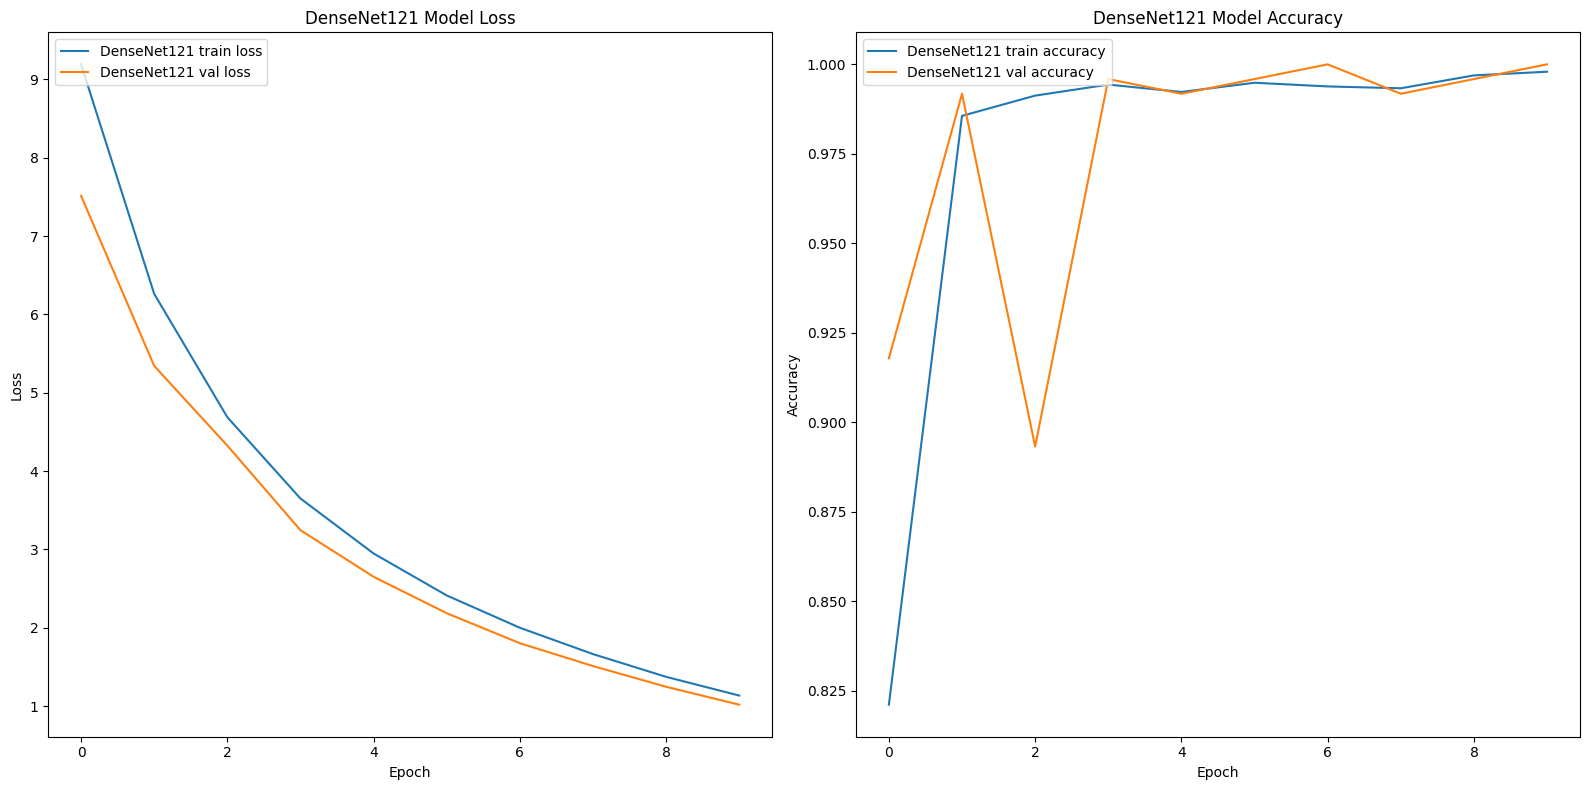

Training AlexNet model...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.1121 - loss: 73.4107 - val_accuracy: 0.1170 - val_loss: 23.1041
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.1881 - loss: 16.8220 - val_accuracy: 0.4025 - val_loss: 6.1602
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3680 - loss: 5.0437 - val_accuracy: 0.4148 - val_loss: 2.9458
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4868 - loss: 2.6122 - val_accuracy: 0.5277 - val_loss: 1.9944
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5719 - loss: 1.9194 - val_accuracy: 0.6407 - val_loss: 1.5754
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6750 - loss: 1.4804 - val_accuracy: 0.7331 - val_loss: 1.3481
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7289 - loss: 1.2950 - val_accuracy: 0.8049 - val_loss: 1.0478
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7654 - loss: 1.1162 - val

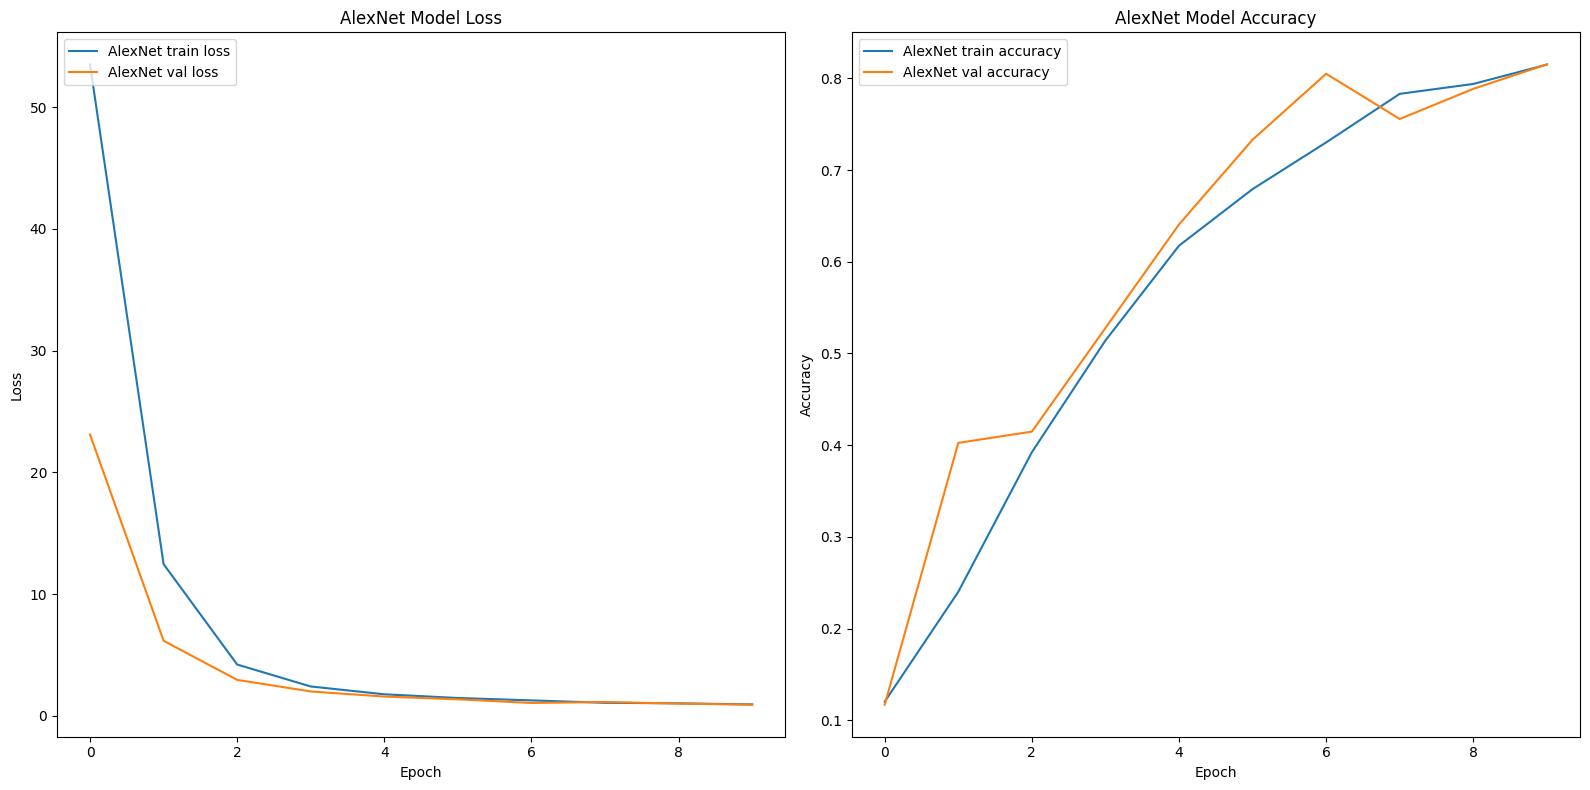

In [14]:
models = ['VGG16', 'VGG19', 'ResNet50', 'DenseNet121', 'AlexNet']
history_dict = {}
best_weights = {}

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

for model_name in models:
    print(f"Training {model_name} model...")
    model = build_model(model_name)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        x_train, y_train,
        batch_size=16,
        epochs=10,
        validation_data=(x_val, y_val),  # Validation data for validation split
        verbose=1
    )

    history_dict[model_name] = history.history
    best_weights[model_name] = model
    print(f"{model_name} model weights saved.")


    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    # Loss plot
    ax[0].plot(history.history['loss'], label=f'{model_name} train loss')
    ax[0].plot(history.history['val_loss'], label=f'{model_name} val loss')
    ax[0].set_title(f'{model_name} Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='upper left')
    # Accuracy plot
    ax[1].plot(history.history['accuracy'], label=f'{model_name} train accuracy')
    ax[1].plot(history.history['val_accuracy'], label=f'{model_name} val accuracy')
    ax[1].set_title(f'{model_name} Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()


# 8. Model Testing

Evaluating VGG16 model on test data...
VGG16 Test Accuracy: 99.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step


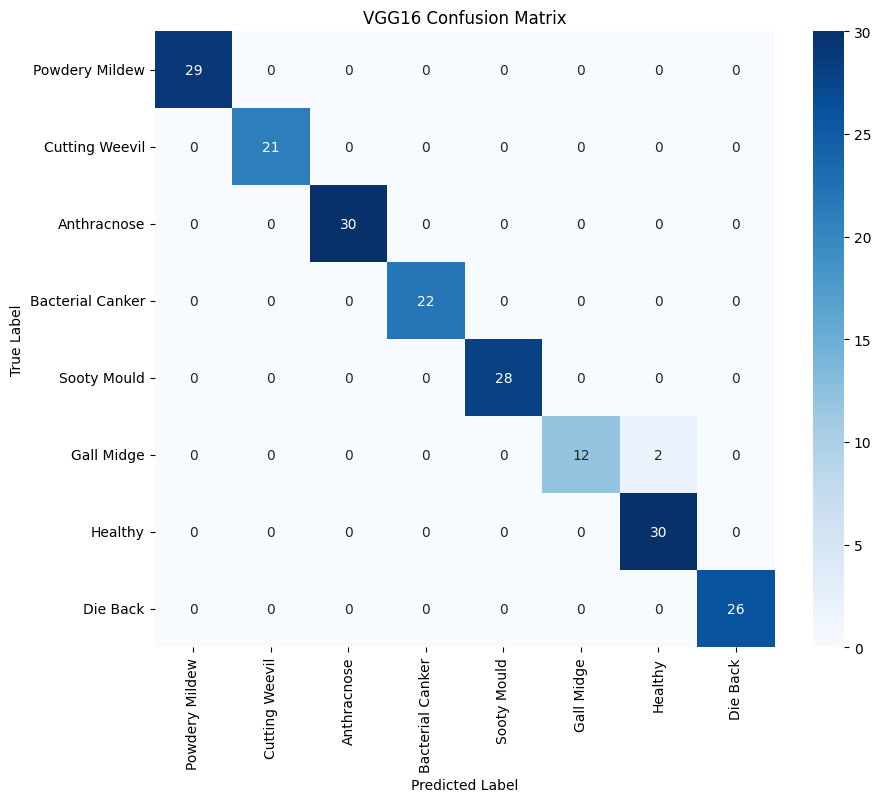

                  precision    recall  f1-score   support

  Powdery Mildew       1.00      1.00      1.00        29
  Cutting Weevil       1.00      1.00      1.00        21
     Anthracnose       1.00      1.00      1.00        30
Bacterial Canker       1.00      1.00      1.00        22
     Sooty Mould       1.00      1.00      1.00        28
      Gall Midge       1.00      0.86      0.92        14
         Healthy       0.94      1.00      0.97        30
        Die Back       1.00      1.00      1.00        26

        accuracy                           0.99       200
       macro avg       0.99      0.98      0.99       200
    weighted avg       0.99      0.99      0.99       200

Evaluating VGG19 model on test data...
VGG19 Test Accuracy: 99.50%
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step


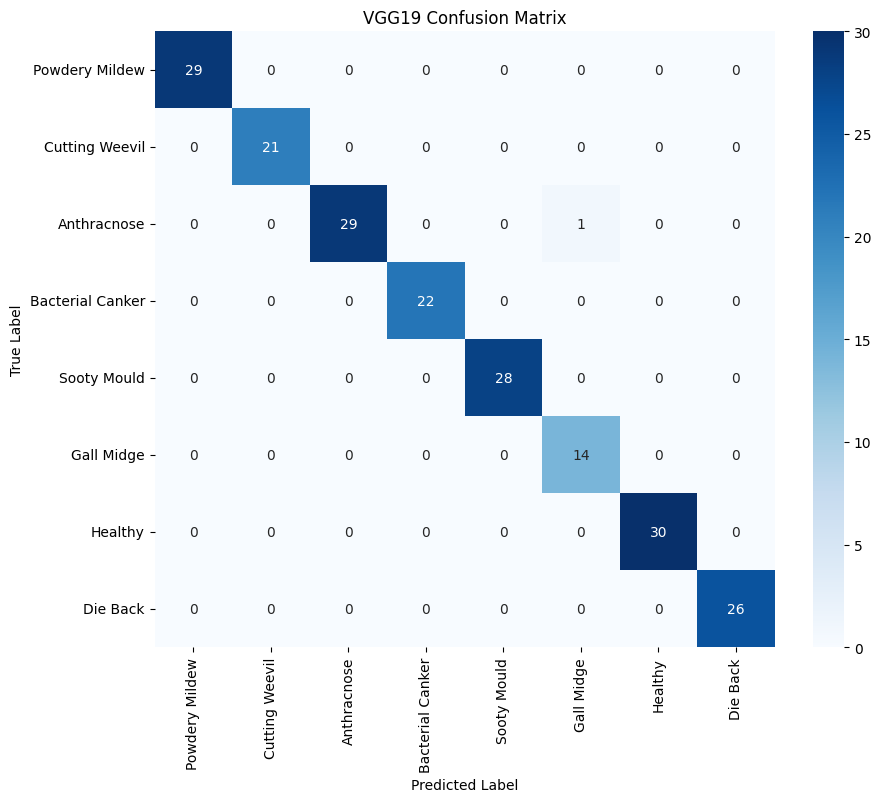

                  precision    recall  f1-score   support

  Powdery Mildew       1.00      1.00      1.00        29
  Cutting Weevil       1.00      1.00      1.00        21
     Anthracnose       1.00      0.97      0.98        30
Bacterial Canker       1.00      1.00      1.00        22
     Sooty Mould       1.00      1.00      1.00        28
      Gall Midge       0.93      1.00      0.97        14
         Healthy       1.00      1.00      1.00        30
        Die Back       1.00      1.00      1.00        26

        accuracy                           0.99       200
       macro avg       0.99      1.00      0.99       200
    weighted avg       1.00      0.99      1.00       200

Evaluating ResNet50 model on test data...
ResNet50 Test Accuracy: 100.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 643ms/step


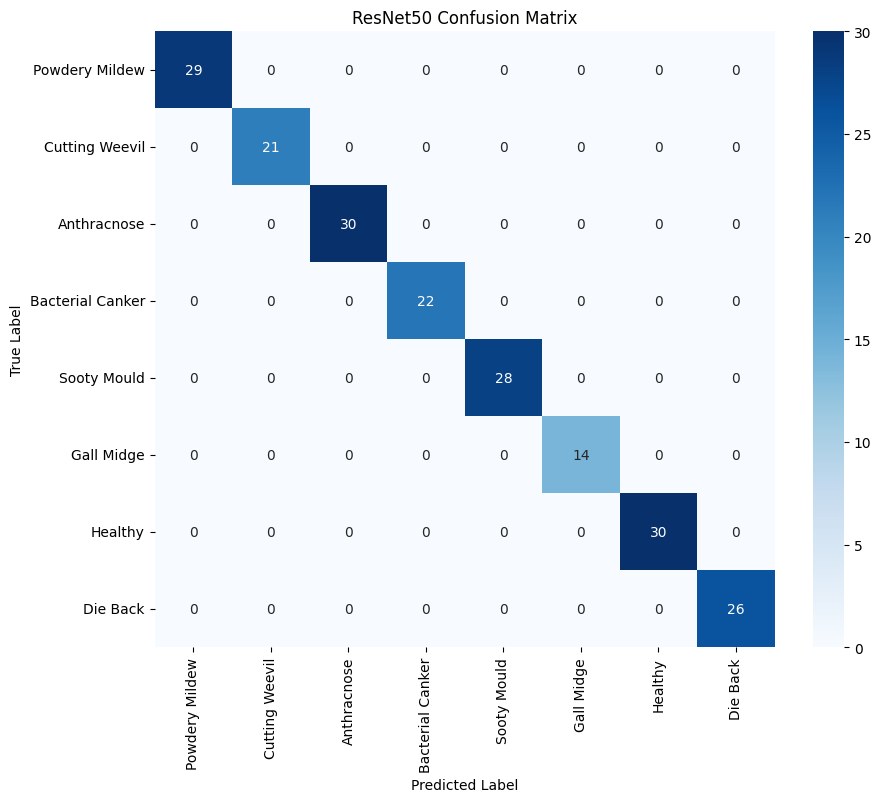

                  precision    recall  f1-score   support

  Powdery Mildew       1.00      1.00      1.00        29
  Cutting Weevil       1.00      1.00      1.00        21
     Anthracnose       1.00      1.00      1.00        30
Bacterial Canker       1.00      1.00      1.00        22
     Sooty Mould       1.00      1.00      1.00        28
      Gall Midge       1.00      1.00      1.00        14
         Healthy       1.00      1.00      1.00        30
        Die Back       1.00      1.00      1.00        26

        accuracy                           1.00       200
       macro avg       1.00      1.00      1.00       200
    weighted avg       1.00      1.00      1.00       200

Evaluating DenseNet121 model on test data...
DenseNet121 Test Accuracy: 100.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


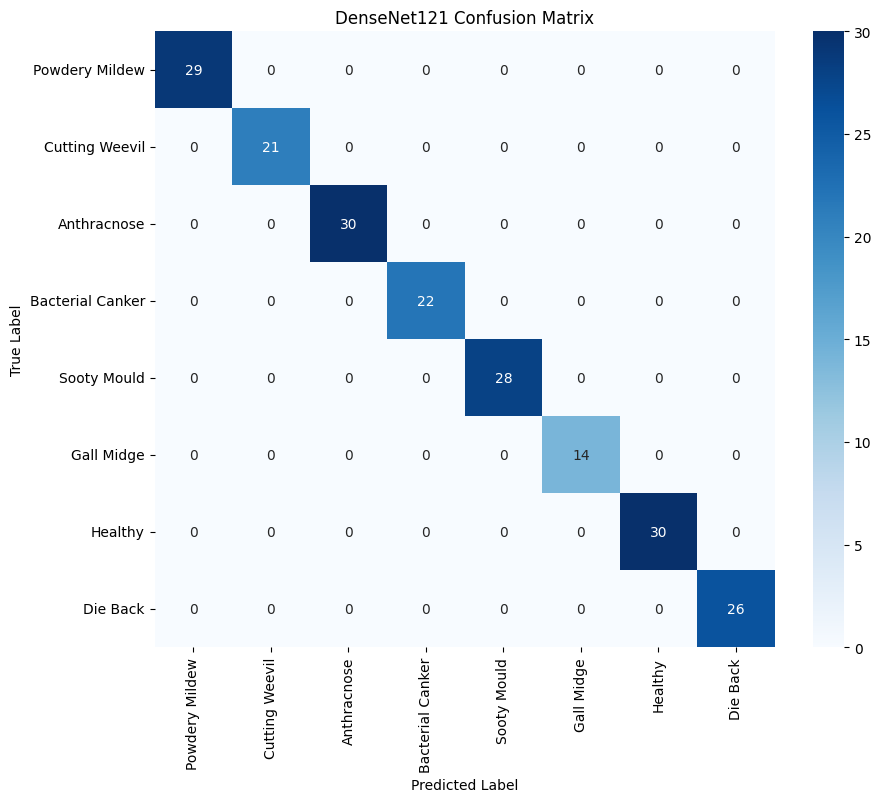

                  precision    recall  f1-score   support

  Powdery Mildew       1.00      1.00      1.00        29
  Cutting Weevil       1.00      1.00      1.00        21
     Anthracnose       1.00      1.00      1.00        30
Bacterial Canker       1.00      1.00      1.00        22
     Sooty Mould       1.00      1.00      1.00        28
      Gall Midge       1.00      1.00      1.00        14
         Healthy       1.00      1.00      1.00        30
        Die Back       1.00      1.00      1.00        26

        accuracy                           1.00       200
       macro avg       1.00      1.00      1.00       200
    weighted avg       1.00      1.00      1.00       200

Evaluating AlexNet model on test data...
AlexNet Test Accuracy: 75.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


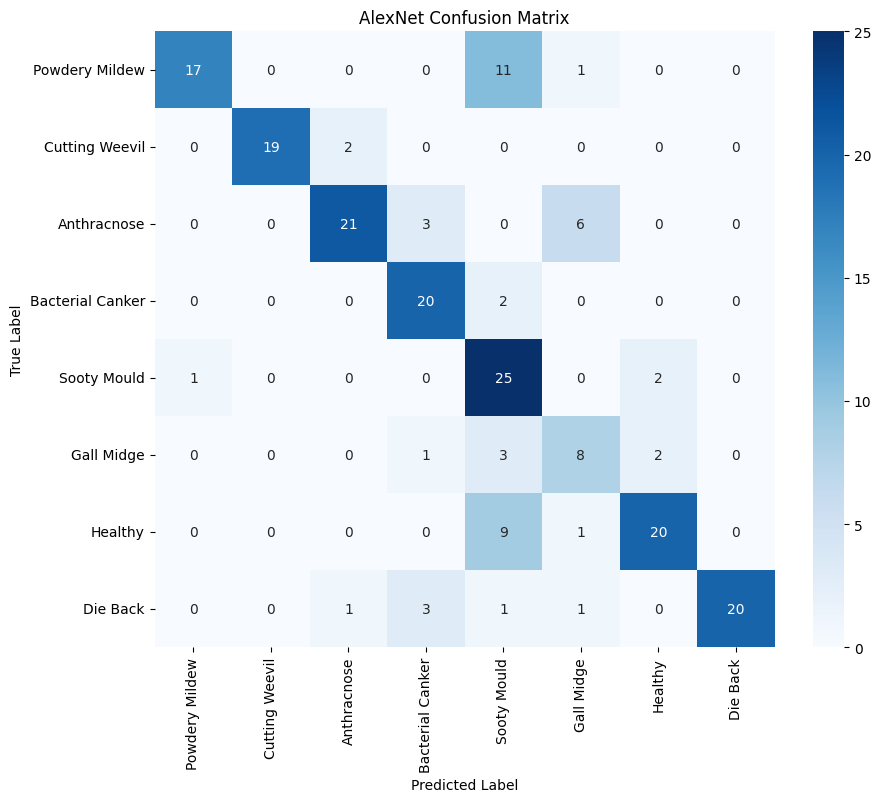

                  precision    recall  f1-score   support

  Powdery Mildew       0.94      0.59      0.72        29
  Cutting Weevil       1.00      0.90      0.95        21
     Anthracnose       0.88      0.70      0.78        30
Bacterial Canker       0.74      0.91      0.82        22
     Sooty Mould       0.49      0.89      0.63        28
      Gall Midge       0.47      0.57      0.52        14
         Healthy       0.83      0.67      0.74        30
        Die Back       1.00      0.77      0.87        26

        accuracy                           0.75       200
       macro avg       0.79      0.75      0.75       200
    weighted avg       0.81      0.75      0.76       200



In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

for model_name in models:
    print(f"Evaluating {model_name} model on test data...")
    model = best_weights[model_name]

    scores = model.evaluate(x_test, y_test, verbose=0)
    print(f"{model_name} Test Accuracy: {scores[1] * 100:.2f}%")

    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    print(classification_report(y_true, y_pred, target_names=classes))




Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


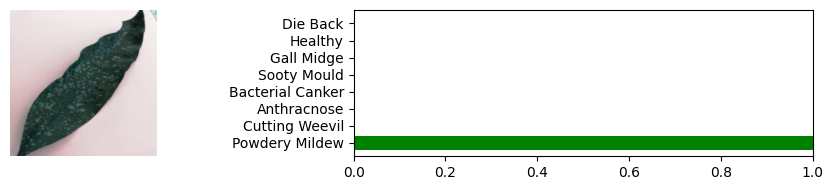



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


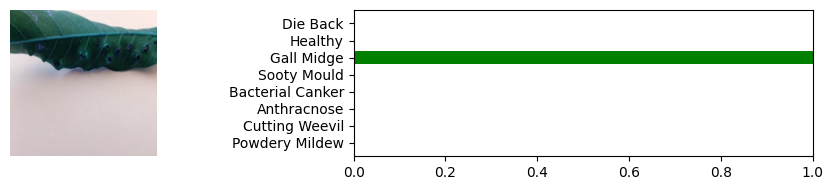



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


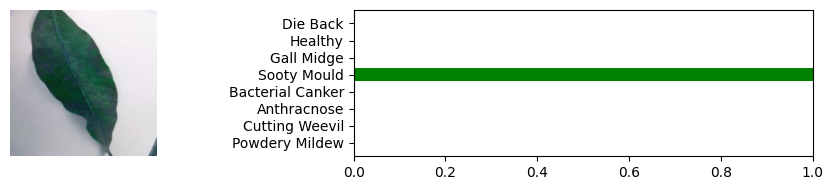



Testing - VGG19 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


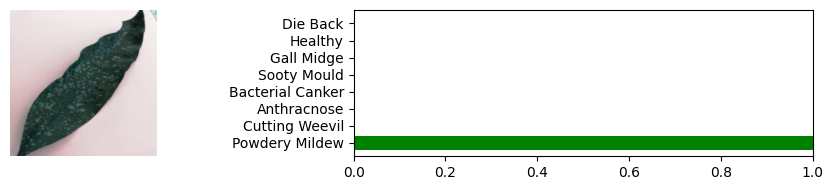



Testing - VGG19 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


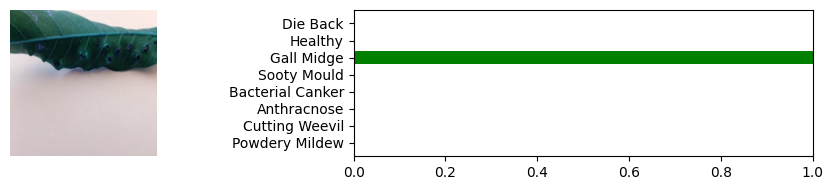



Testing - VGG19 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


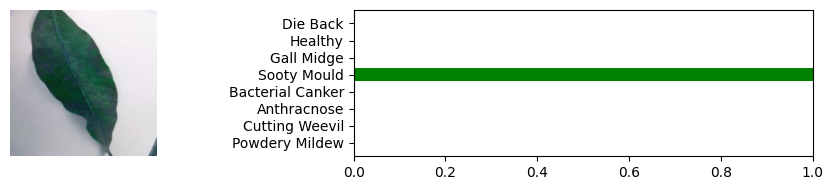



Testing - ResNet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


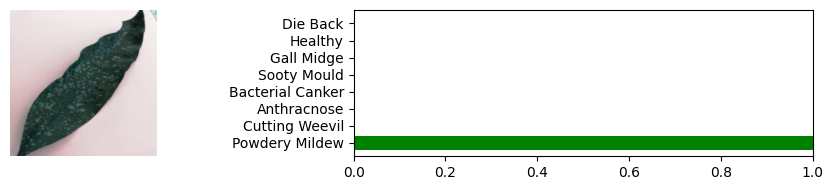



Testing - ResNet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


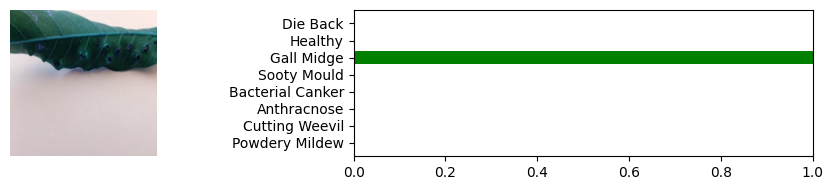



Testing - ResNet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


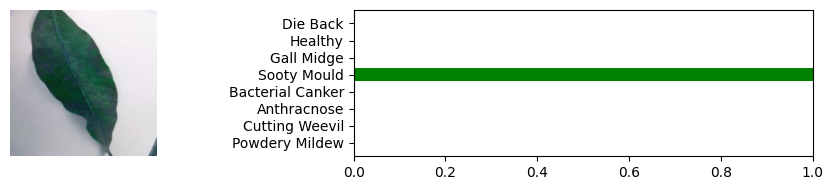



Testing - DenseNet121 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


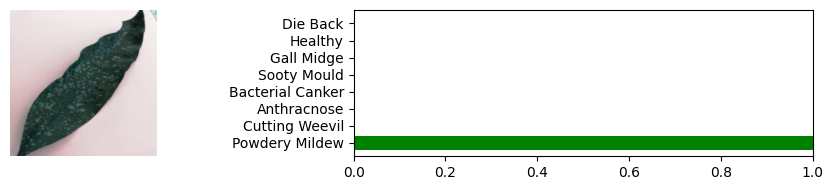



Testing - DenseNet121 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


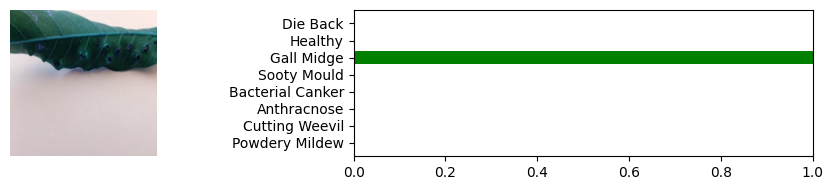



Testing - DenseNet121 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


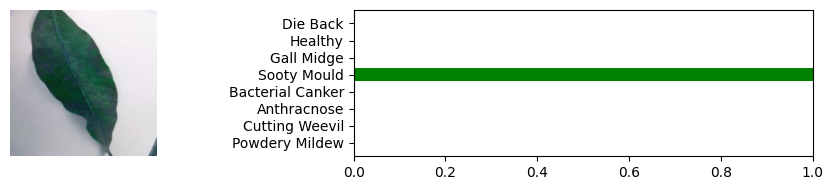



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


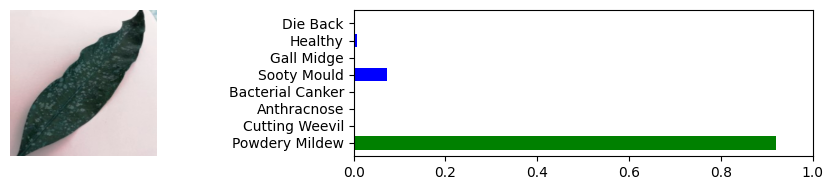



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


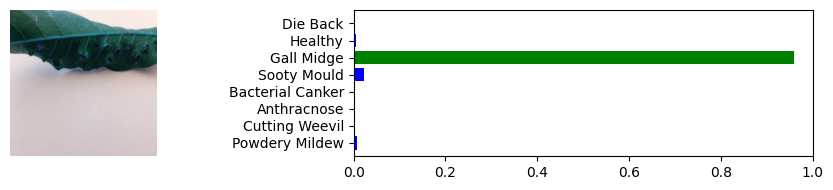



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


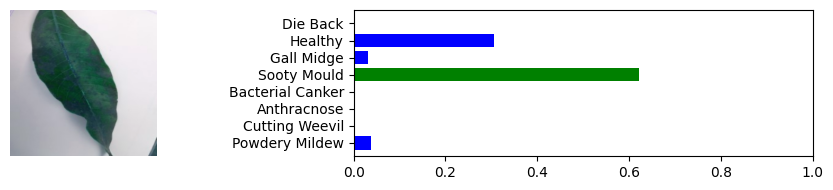

In [16]:

for model_name in models:
    for i in x_test[100:103]:
        print(f"\n\nTesting - {model_name} Model\n")
        output_plot(i, best_weights[model_name])




Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


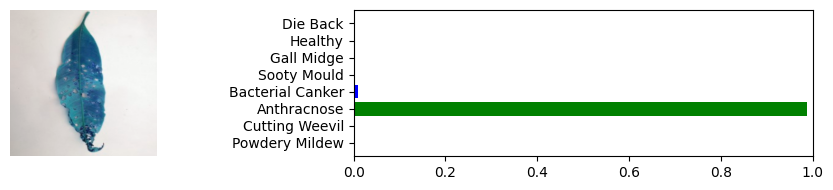



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


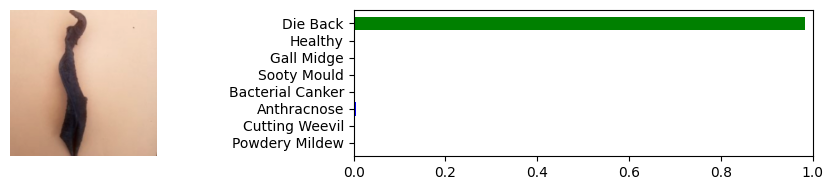



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


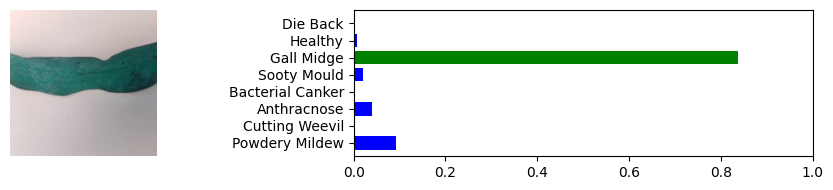



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


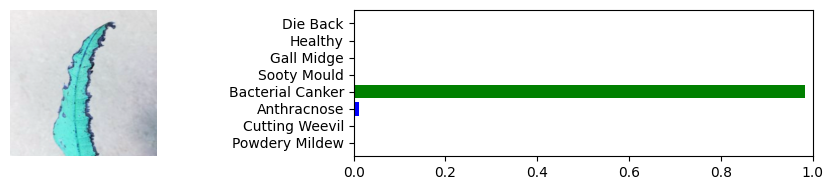



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


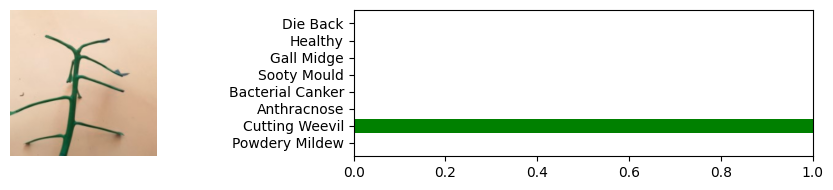

In [17]:
# Customize the codes as per your like
for i in x_test[50:55]:
    print(f"\n\nTesting - {model_name} Model\n")
    output_plot(i, best_weights['AlexNet'])



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


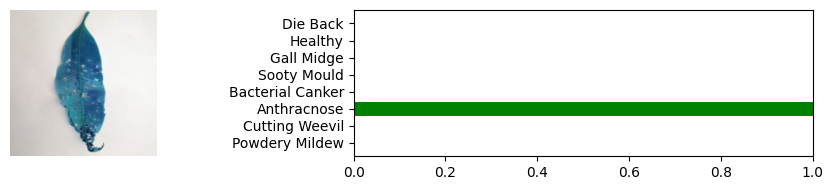



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


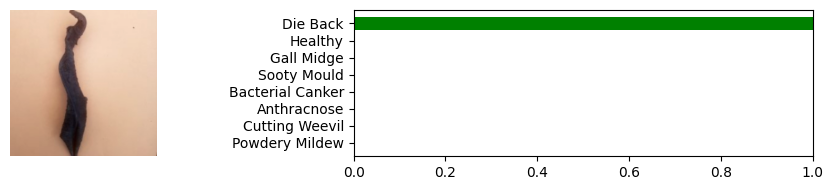



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


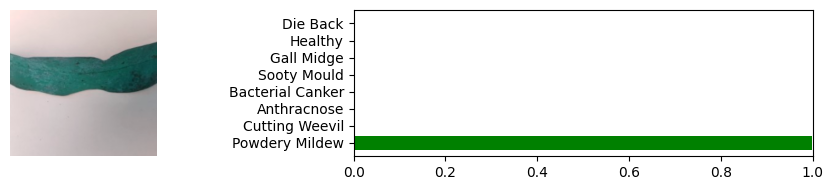



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


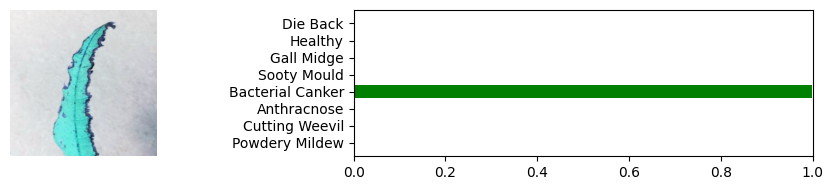



Testing - AlexNet Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


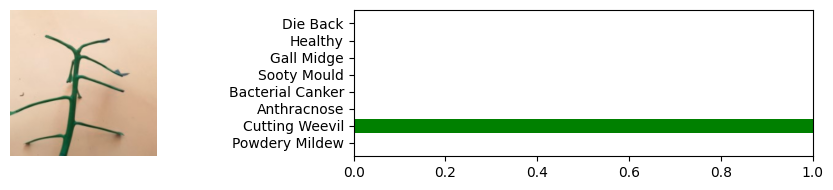

In [18]:
for i in x_test[50:55]:
    print(f"\n\nTesting - {model_name} Model\n")
    output_plot(i, best_weights['DenseNet121'])